<a href="https://colab.research.google.com/github/viniciused26/fastaiOnCampus/blob/main/nbs/lesson01_160147816_viniciused26_vinicius_edwardo_pereira_oliveira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## É cutia?

O Brasil possui uma biodiversidade bastante ampla, diferentes espécies de animais podem ser encontradas no território nacional. Um dos animais mais populares é a capivara, o maior roedor do mundo, mas também existem outros roedores que compartilham o mesmo habitat e possuem um tamanho maior do que o comum para animais desse tipo. A cutia é um roedor de porte menor, mas que apresenta características similares à capivara. 

Utilizando técnincas de aprendizado de máquina, o exercício a seguir busca determinar quais imagens representam cada animal.

In [11]:
# instalando dependências necessárias

!pip install -Uqq fastai duckduckgo_search

## Passo 1: Baixar imagens de capivaras e cutias

In [62]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Para facilitar a busca e encontrar resultados mais concisos, utiliza-se o nome científico da capivara e da cutia.


In [61]:
urls = search_images('Hydrochoerus hydrochaeris', max_images=1)
urls[0]

Searching for 'Hydrochoerus hydrochaeris'


'https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/2-capybara-hydrochoerus-hydrochaeris-panoramic-images.jpg'

Após coletar o URL, baixamos a imagem. Aqui está um exemplo:

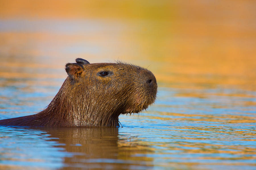

In [32]:
from fastdownload import download_url
dest = 'capivara.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Repetimos o processo para a cutia.

Searching for 'Dasyprocta punctata'


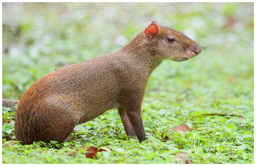

In [33]:
download_url(search_images('Dasyprocta punctata', max_images=1)[0], 'cutia.jpg', show_progress=False)
Image.open('cutia.jpg').to_thumb(256,256)

Agora, iremos buscar novos exemplos de ambos animais e além de buscar mais diferentes uma das outras. Com isso, criamos uma pasta para armazenar as imagens coletadas.

In [36]:
searches = 'Hydrochoerus hydrochaeris','Dasyprocta punctata'
path = Path('capybara_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10) 
    download_images(dest, urls=search_images(f'{o} body photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} eating photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Hydrochoerus hydrochaeris photo'
Searching for 'Hydrochoerus hydrochaeris body photo'
Searching for 'Hydrochoerus hydrochaeris eating photo'
Searching for 'Dasyprocta punctata photo'
Searching for 'Dasyprocta punctata body photo'
Searching for 'Dasyprocta punctata eating photo'


## Passo 2: Treinar o modelo

Aqui removemos as fotos que não foram baixadas corretamente, para que não atrapalhe no treinamento do modelo.

In [37]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Usando o método disponibilizado pela biblioteca `fastai` criamos `DataLoaders` que são objetos com as imagens usadas para criar o modelo e imagens de validação, usadas para verificar a precisão deste modelo.

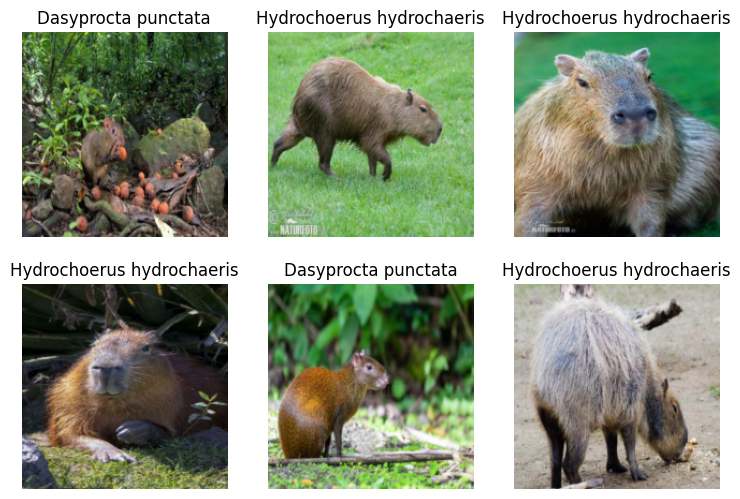

In [63]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Utilizando a função `vision_learner`, os nossos `DataLoaders` e a arquitetura de rede neural `resnet18`, nós treinamos nosso modelo e verificamos os seus resultados.

In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.935807,0.038613,0.019231,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.199322,0.067866,0.019231,00:45
1,0.143265,0.122973,0.057692,00:46
2,0.111902,0.049492,0.019231,00:46


## Passo 3: Utilizando o modelo

Aqui conseguimos usar o modelo para validar imagens coletadas de exemplo.

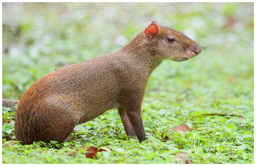

In [64]:
Image.open("cutia.jpg").to_thumb(256,256)

In [73]:
is_cutia,_,probs = learn.predict(PILImage.create('cutia.jpg'))

if is_cutia == 'Dasyprocta punctata':
  is_cutia = 'cutia'
else:
  is_cutia = 'capivara'

print(f"Isso é uma {is_cutia}!")
print(f"Probabilidade de ser uma cutia: {probs[0]:.4f}")

Isso é uma cutia!
Probabilidade de ser uma cutia: 1.0000


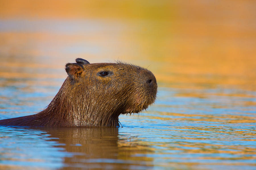

In [65]:
Image.open("capivara.jpg").to_thumb(256,256)

In [74]:


is_cutia,_,probs = learn.predict(PILImage.create('capivara.jpg'))

if is_cutia == 'Dasyprocta punctata':
  is_cutia = 'cutia'
else:
  is_cutia = 'capivara'

print(f"Isso é uma {is_cutia}!")
print(f"Probabilidade de ser uma cutia: {probs[0]:.4f}")

Isso é uma capivara!
Probabilidade de ser uma cutia: 0.0397


E percebemos que ele obteve resultados corretos e satisfatórios, agora possuímos um modelo capaz de diferenciar cutias de capivaras.